# Match Trigger and Event Catalog

## Import Libraries

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.signal.trigger import coincidence_trigger
from obspy import UTCDateTime
from numpy import sort, argmin, array
from pandas import DataFrame, value_counts, merge

from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.catalog_to_dataframe import __catalog_to_dataframe

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['time_period'] = "20221001_20230615"

config['BSPF_lon'] = array([-116.455439])
config['BSPF_lat'] = array([33.610643])

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['catalog_filename'] = f"BSPF_catalog_{config['time_period']}_all.xml"

config['output_filename'] = f"BSPF_catalog_{config['time_period']}_triggered.xml"

config['client'] = Client("IRIS")

In [4]:
!ls /import/kilauea-data/BSPF/data/catalogs/

BSPF_catalog_20221001_20230331_triggered.pkl
BSPF_catalog_20221001_20230331_triggered.xml
BSPF_catalog_20221001_20230531_all.pkl
BSPF_catalog_20221001_20230531_all.xml
BSPF_catalog_20221001_20230615_all.pkl
BSPF_catalog_20221001_20230615_all.xml
BSPF_catalog_20221001_20230615_triggered.pkl
BSPF_catalog_20221001_20230615_triggered.xml
BSPF_catalog_extended_20221001_20230531_all.pkl
BSPF_catalog_extended_20221001_20230531_all.xml
BSPF_catalog_extended_20221001_20230615_all.pkl
BSPF_catalog_extended_20221001_20230615_all.xml
gcmt_solutions_20221001_20230531.xml
gcmt_solutions_20221001_20230615.xml
gmt_usgs_m3_m4.xml
tmp
trigger_20221001_20230331.pkl
trigger_20221001_20230615.pkl
trigger_20230401_20230615.pkl
trigger_all_errors.pkl
triggered_2022-10-01_2022-10-15.pkl
triggered_2022-10-01_2023-06-15.pkl


##  join catalogs

In [5]:
# from andbro__store_as_pickle import __store_as_pickle

# trigger_old = __read_pickle(config, config['path_to_catalogs'], "trigger_20221001_20230331.pkl")
# trigger_new = __read_pickle(config, config['path_to_catalogs'], "trigger_20230401_20230615.pkl")
# trigger_all = trigger_old + trigger_new

# print(len(trigger_old), len(trigger_new), len(trigger_all))

# __store_as_pickle(trigger_all, config['path_to_catalogs']+"trigger_20221001_20230615.pkl")

## Load Catalog

In [6]:
## read catalog
cat = obs.read_events(config['path_to_catalogs']+config['catalog_filename'])
cat.events.sort(key=lambda event: event.origins[0].time)

## Load Triggered Events

In [7]:
def __read_pickle(config, path, filename):
    
    import pickle

    with open(path+filename, 'rb') as f:
        triggerfile = pickle.load(f)
        
    return triggerfile

In [8]:
trigger_events = __read_pickle(config, config['path_to_catalogs'], "triggered_2022-10-01_2023-06-15.pkl")

In [13]:
times, cosum, times_rel = [], [], []
ref_time = obs.UTCDateTime("2022-10-01")

for trig in trigger_events:
    times.append(trig['time'])
    cosum.append(trig['coincidence_sum'])
    times_rel.append((trig['time']-ref_time)/86400)
                          
trigger_times = sort(times)

coinc4 = [ev for ev in trigger_events if ev['coincidence_sum'] == 4]
coinc5 = [ev for ev in trigger_events if ev['coincidence_sum'] == 5]
coinc6 = [ev for ev in trigger_events if ev['coincidence_sum'] == 6]

In [15]:
df_trig = DataFrame()
df_trig['coincidence_sum'] = cosum
df_trig['trig_times_relative'] = times_rel
df_trig['trigger_time'] = trigger_times
df_trig['trigger_time'] = df_trig['trigger_time'].astype(str)

## remove duplicates of trigger time
df_trig = df_trig.drop_duplicates(["trigger_time"], keep="first").reset_index()

## remove trigger times before reference time
df_trig = df_trig[df_trig.trig_times_relative > 0]

trigger_times_unique = df_trig.trigger_time

print(f" removing duplicates")
print(f" before:  {len(trigger_times)}")
print(f" after:   {len(df_trig.trigger_time)}")

 removing duplicates
 before:  1886
 after:   1021


In [16]:
coinc0 = df_trig[df_trig.coincidence_sum >= 0]
coinc4 = df_trig[df_trig.coincidence_sum == 4]
coinc5 = df_trig[df_trig.coincidence_sum == 5]
coinc6 = df_trig[df_trig.coincidence_sum == 6]

In [18]:
print(f" total events:      {len(cat)}")
print(f" triggered events:  {len(trigger_events)}")

print(f" CoInc. = 4:        {len(coinc4)} ({round(len(coinc4)/len(coinc0)*100,1)} %)")
print(f" CoInc. = 5:        {len(coinc5)} ({round(len(coinc5)/len(coinc0)*100,1)} %)")
print(f" CoInc. = 6:        {len(coinc6)} ({round(len(coinc6)/len(coinc0)*100,1)} %)")

 total events:      7578
 triggered events:  1886
 CoInc. = 4:        175 (17.1 %)
 CoInc. = 5:        100 (9.8 %)
 CoInc. = 6:        746 (73.1 %)


## Match events of triggered catalog with event catalog

In [19]:
def __expected_arrival_times(catalog, sta_lat, sta_lon):
    
    from obspy.geodetics import locations2degrees
    from obspy.taup import TauPyModel

    model = TauPyModel(model="ak135") ## "ak135"
    
    expected_times, expected_paths = [], []
    for jj, ev in enumerate(catalog):
        if jj == 300: 
            break
            
        ev_lat = ev.origins[0].latitude
        ev_lon = ev.origins[0].longitude
        ev_dep = ev.origins[0].depth / 1000
        ev_time = ev.origins[0].time
        
        dist_deg = locations2degrees(sta_lat, sta_lon, ev_lat, ev_lon)

        try:
            arrivals = model.get_travel_times(source_depth_in_km=ev_dep,
                                              distance_in_degree=dist_deg,
                                              phase_list=["P","S","pP","sS"]
                                             )
            print(arrivals)
            expected_times.append(ev_time + arrivals[0].time)
        except:
            print(f" -> failed to compute arrival times")
            
        try:
            paths = model.get_ray_paths(source_depth_in_km=ev_dep,
                                        distance_in_degree=dist_deg,
                                        phase_list=["P","S","pP","sS"]
                                        )
            expected_paths.append(paths)
            
        except:
            print(f" -> failed to compute arrival paths")
            
    return expected_times, expected_paths
                                         
expected_times, expected_paths = __expected_arrival_times(cat[:20], config['BSPF_lat'], config['BSPF_lon'])

expected_times, expected_paths

0 arrivals
	
 -> failed to compute arrival times
18 arrivals
	P phase arrival at 33.060 seconds
	pP phase arrival at 33.744 seconds
	P phase arrival at 34.999 seconds
	pP phase arrival at 35.448 seconds
	P phase arrival at 35.465 seconds
	pP phase arrival at 35.953 seconds
	P phase arrival at 36.072 seconds
	P phase arrival at 36.582 seconds
	pP phase arrival at 36.774 seconds
	S phase arrival at 57.308 seconds
	sS phase arrival at 58.362 seconds
	S phase arrival at 58.918 seconds
	sS phase arrival at 59.649 seconds
	S phase arrival at 59.718 seconds
	S phase arrival at 60.467 seconds
	sS phase arrival at 60.519 seconds
	S phase arrival at 61.323 seconds
	sS phase arrival at 61.644 seconds
16 arrivals
	P phase arrival at 20.764 seconds
	P phase arrival at 21.071 seconds
	pP phase arrival at 21.372 seconds
	pP phase arrival at 21.507 seconds
	P phase arrival at 21.521 seconds
	P phase arrival at 21.871 seconds
	pP phase arrival at 22.448 seconds
	pP phase arrival at 22.666 seconds
	S ph

([2022-10-01T04:07:25.399645Z,
  2022-10-01T04:31:10.814190Z,
  2022-10-01T05:53:04.684638Z,
  2022-10-01T06:19:50.186289Z,
  2022-10-01T09:23:09.437025Z,
  2022-10-01T09:28:18.174378Z,
  2022-10-01T09:33:14.641784Z,
  2022-10-01T10:28:15.343523Z,
  2022-10-01T10:55:09.668323Z,
  2022-10-01T10:55:25.502689Z,
  2022-10-01T11:09:36.757789Z,
  2022-10-01T16:05:39.720572Z,
  2022-10-01T18:27:18.650042Z],
 [[],
  [<obspy.taup.helper_classes.Arrival object at 0x7fb976bbf3d0>, <obspy.taup.helper_classes.Arrival object at 0x7fb976b52210>, <obspy.taup.helper_classes.Arrival object at 0x7fb976bbf250>, <obspy.taup.helper_classes.Arrival object at 0x7fb976b52510>, <obspy.taup.helper_classes.Arrival object at 0x7fb976bab790>, <obspy.taup.helper_classes.Arrival object at 0x7fb976b8f7d0>, <obspy.taup.helper_classes.Arrival object at 0x7fb9bcffda90>, <obspy.taup.helper_classes.Arrival object at 0x7fb976bb8910>, <obspy.taup.helper_classes.Arrival object at 0x7fb976bab690>, <obspy.taup.helper_classes.Ar

no


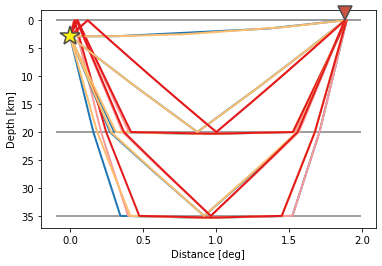

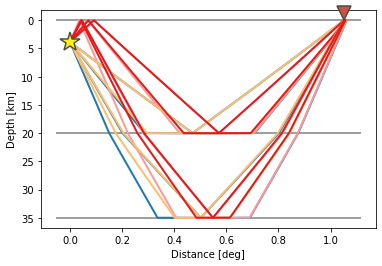

no


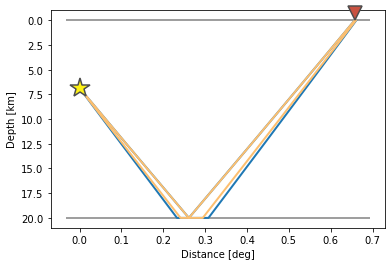

no


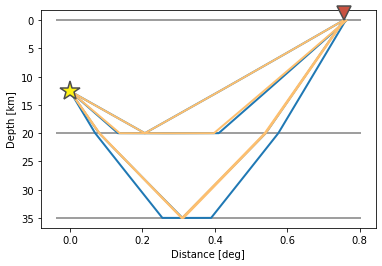

no


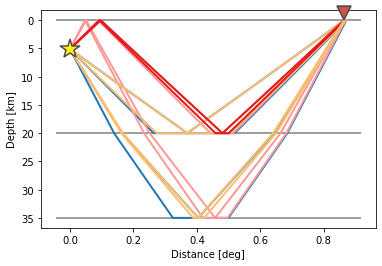

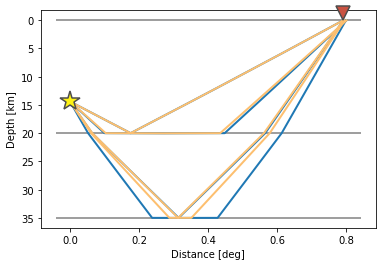

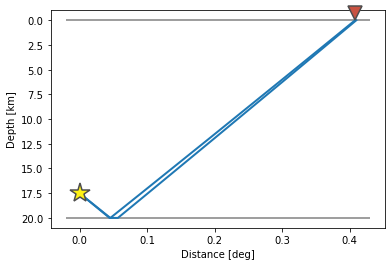

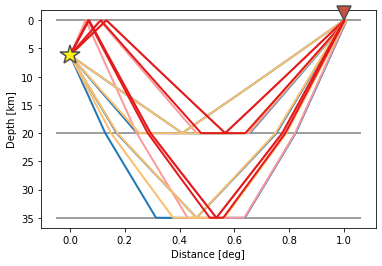

no


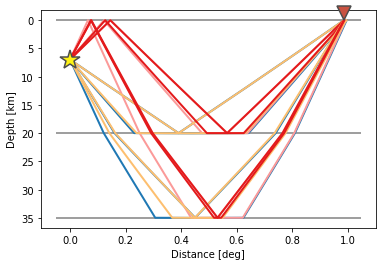

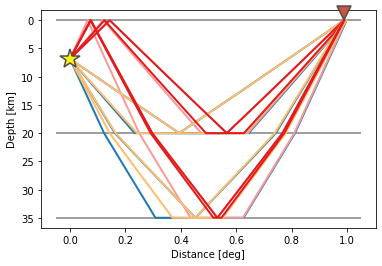

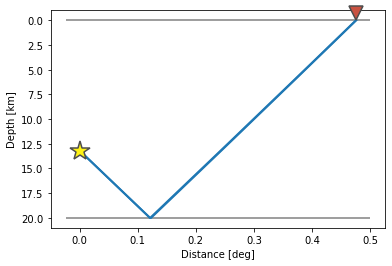

no
no


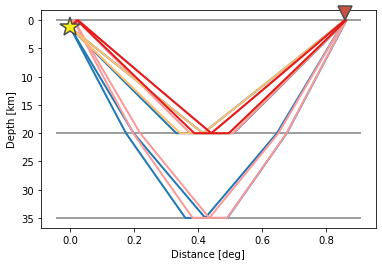

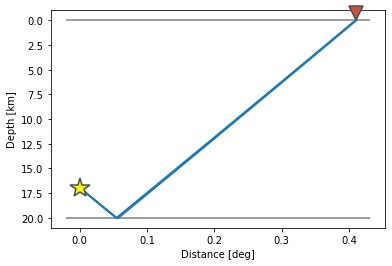

In [20]:
for path in expected_paths:
    try:
        ax = path.plot_rays(plot_type="cartesian")
    except:
        print("no")

### Match triggers with event catalog based on travel time estimates

In [21]:
def __find_matches(catalog, sta_lat, sta_lon, trig_times, max_time_offset):
    
    from obspy.geodetics import locations2degrees
    from obspy.taup import TauPyModel
    from obspy import UTCDateTime, Catalog
    from tqdm.notebook import tqdm

    ## model for arrival times
    model = TauPyModel(model="ak135") ## "ak135", "iasp91", "prem"
    
    ## counter for failed arrival computations
    fails = 0
    
    ## output dataframe
    df_out = DataFrame(columns=["id", "event_time", "arrival_time", "trigger_time"])
    
    ## output catalog
    cat_out = Catalog()
    
    for jj, ev in enumerate(tqdm(catalog)):

        ## extract event data
        ev_lat = ev.origins[0].latitude
        ev_lon = ev.origins[0].longitude
        ev_dep = ev.origins[0].depth / 1000
        ev_time = ev.origins[0].time
        
        ## compute distance between station to event in degrees
        dist_deg = locations2degrees(sta_lat, sta_lon, ev_lat, ev_lon)
        
        
#         print(dist_deg[0], ev_dep)

        try:
            arrivals = model.get_travel_times(source_depth_in_km=ev_dep,
                                              distance_in_degree=dist_deg[0],
                                              phase_list=["P","S","pP","sS","sP","pS"]
                                             )
            
            expected_time = ev_time + arrivals[0].time
            
        except Exception as e:
            fails += 1
#             print(ev.origins[0].time, dist_deg, ev_dep)
#             print(f" -> {jj} failed to compute arrival times")
            continue
    
        for nn, trig in enumerate(trig_times): 
            
            ## compute absolute temporal distance
            abs_diff = abs(expected_time - UTCDateTime(trig))
            
            ## if distance below threshold, trigger is considered match with catalog event
            if abs_diff < max_time_offset:
#                 print(nn, trig)
                
                ## add row to dataframe
                df_out.loc[len(df_out)] = [jj, ev_time, expected_time, trig]
                
                ## add to catalog
                cat_out += ev
                
                break
    
    print(f" -> failed for {fails} of {len(catalog)} to compute arrival times..:")
    
    return df_out, cat_out                                

In [22]:
df_out, cat_select = __find_matches(cat, config['BSPF_lat'], config['BSPF_lon'], trigger_times_unique, max_time_offset=20)

  0%|          | 0/7578 [00:00<?, ?it/s]

 -> failed for 308 of 7578 to compute arrival times..:


In [23]:
df_all = merge(df_trig, df_out, on=['trigger_time'])
df_all

,index,coincidence_sum,trig_times_relative,trigger_time,id,event_time,arrival_time
0,7,4.0,0.510553,2022-10-01T05:36:10.344538Z,3,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:15.816780Z
1,38,6.0,0.867477,2022-10-01T21:26:51.694538Z,21,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:55.332138Z
2,49,6.0,1.142584,2022-10-02T03:25:19.269538Z,32,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:20.869968Z
3,56,6.0,1.159144,2022-10-02T15:51:37.444539Z,42,2022-10-02T15:51:37.180000Z,2022-10-02T15:51:41.755137Z
4,58,6.0,1.284144,2022-10-02T21:52:57.394539Z,49,2022-10-02T21:52:54.280000Z,2022-10-02T21:52:59.069507Z
...,...,...,...,...,...,...,...
315,1832,4.0,247.723727,2023-06-05T17:23:13.670000Z,7314,2023-06-05T17:22:59.900000Z,2023-06-05T17:23:11.132115Z
316,1832,4.0,247.723727,2023-06-05T17:23:13.670000Z,7315,2023-06-05T17:23:05.920000Z,2023-06-05T17:23:17.078772Z
317,1848,6.0,248.998727,2023-06-07T06:03:52.040000Z,7347,2023-06-07T06:03:42.030000Z,2023-06-07T06:03:54.073220Z
318,1866,6.0,252.998727,2023-06-11T02:38:28.860000Z,7452,2023-06-11T02:38:25.290000Z,2023-06-11T02:38:31.166238Z


## Reject manually selected events of false positive triggers

In [46]:
## list of events to reject (manually)
no_event = ["2022-10-05 15:39:13.690", 
            "2022-10-05 15:42:03.610",
            "2022-10-05 18:35:16.860",
            "2022-10-10 05:48:52.890",
            "2022-10-12 19:12:14.670",
            "2022-10-12 23:08:11.410",
            "2022-10-12 23:58:00.800",
            "2022-10-14 03:13:56.380",
            "2022-10-16 08:42:24.970",
            "2022-10-26 08:27:09.860",
            "2022-10-28 12:47:26.910",
            "2022-11-03 05:53:34.230",
            "2022-11-09 00:46:57.550",
            "2022-11-10 16:53:29.940",
            "2022-11-25 10:45:36.390",
            "2022-12-06 21:56:31.330",
            "2022-12-09 06:03:03.220",
            "2022-12-15 13:55:13.460",
            "2022-12-17 18:02:34.910",
            "2022-12-19 15:41:22.380",
            "2022-12-19 15:41:26.020",
            "2023-01-05 09:59:04.210",
            "2023-01-07 12:32:45.250",
            "2023-01-16 00:00:36.100",
            "2023-01-29 23:50:47.770",
            "2023-02-05 23:38:46.670",
            "2023-02-22 05:09:39.970",
            "2023-03-09 11:49:06.640",
            "2023-03-17 07:12:56.970",
            "2023-03-24 13:59:00.160",
            "2023-03-29 19:23:29.470",
            "2023-03-29 19:23:27.460",
            "2023-04-06 02:42:00.600",
            "2023-04-13 23:57:53.950",
            "2023-04-17 15:27:56.450",
            "2023-05-01 02:52:56.160",
            "2023-06-02 20:19:46.740",
            "2023-06-05 07:39:16.650",
           ]

no_event_utc = list(map(UTCDateTime, no_event))

n_before = len(df_all)

## remove defined events from data frame
df_all = df_all[df_all['event_time'].apply(lambda x: x not in no_event_utc)].reset_index()

## remove defined events from catalog 
new_cat = obs.Catalog()
for tmp_ev in cat_select:
    if tmp_ev.origins[0].time not in no_event_utc:
        new_cat += tmp_ev
cat_select = new_cat


print(f" before:  {n_before} \n after:   {len(df_all)} \n rejected: {len(no_event_utc)}")

ValueError: cannot insert level_0, already exists

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb96c7a0710>], dtype=object)

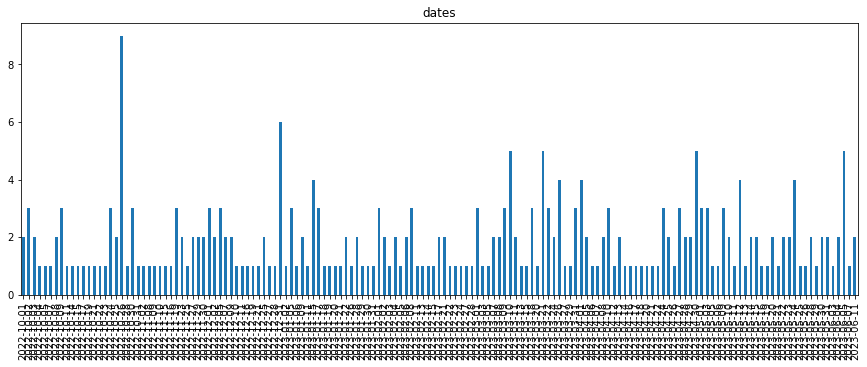

In [47]:
dates = [str(cat_select[ii].origins[0].time.date) for ii in range(len(cat_select))]

df = DataFrame()
df['dates'] = dates
df = df.sort_values(by="dates")

df2 = df.apply(value_counts)
df2.sort_index(inplace=True)

df2.dates.plot(kind='bar', subplots=True, figsize=(15,5))

## Create Catalog of triggered events that were matched with catalog events

In [48]:
cat_select.write(config['path_to_catalogs']+config['output_filename'], format="QUAKEML")
print(f" -> storing: {config['path_to_catalogs']}{config['output_filename']} ...")

 -> storing: /import/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20230615_triggered.xml ...


In [49]:
cata_df = __catalog_to_dataframe(cat_select)

cata_df = cata_df.rename_axis('origin').reset_index()
cata_df['seconds'] = [abs(UTCDateTime(str(tt))-UTCDateTime("2022-10-01")) for tt in cata_df.origin]
cata_df['trigger_time'] = df_all.trigger_time
cata_df['arrival_time'] = df_all.arrival_time
cata_df['event_time'] = df_all.event_time
cata_df['cosum'] = df_all.coincidence_sum

data_df = __add_distances_and_backazimuth(config['BSPF_lat'], config['BSPF_lon'], cata_df)


cata_df.to_pickle(config['path_to_catalogs']+config['output_filename'].replace(".xml",".pkl"))
print(f" -> storing: {config['path_to_catalogs']}{config['output_filename'].replace('.xml','.pkl')}...")

 -> storing: /import/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20230615_triggered.pkl...
